In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score



# Load the merged and preprocessed data
data = pd.read_csv("FINAL_DATASET_2022_23_24.csv")

# Prepare features and target
X = data.drop(columns=['GHI', 'Date'])
y = data['GHI']

# One-hot encode the 'City' categorical variable
X = pd.get_dummies(X, columns=['City'], drop_first=True)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
# Perform 5-fold cross-validation using negative mean absolute error (neg MAE)
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
mae_scores = -cv_scores

# Train model on training data
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")
print(f"MAPE: {mape*100:.2f}%")
print("Cross-validated MAE scores for each fold:", mae_scores)
print(f"Average cross-validated MAE: {mae_scores.mean():.3f}")


MAE: 0.426
MSE: 0.344
RMSE: 0.587
R² Score: 0.829
MAPE: 11.73%
Cross-validated MAE scores for each fold: [0.39131815 0.5651025  0.76765868 0.59972063 0.60391232]
Average cross-validated MAE: 0.586


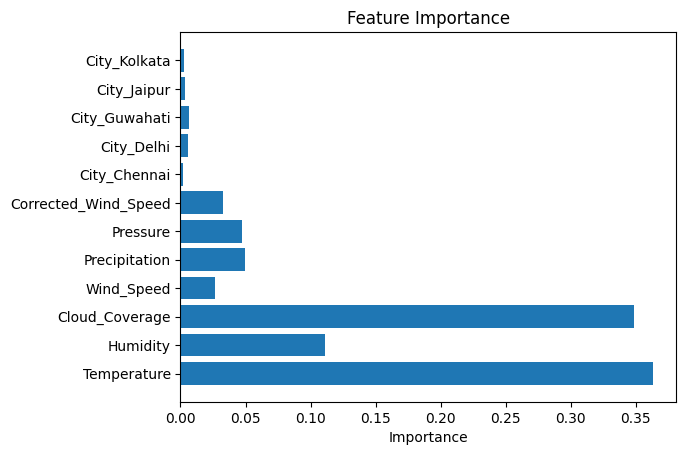

In [14]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
features = X_train.columns  

plt.barh(features, importances)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()


In [15]:
import joblib
joblib.dump(model, "solar_rf_model.pkl")

['solar_rf_model.pkl']

In [17]:
#CONFIGURATION
import requests
api_key = "1721bbd85f1d9ddf83e291483965ba95"  

supported_cities = ["Chennai", "Delhi", "Guwahati", "Jaipur", "Kolkata"]
city = input(f"Enter city name ({', '.join(supported_cities)}): ")
while city not in supported_cities:
    print("City not supported. Try again.")
    city = input(f"Enter city name ({', '.join(supported_cities)}): ")

def fetch_weather_data(city_name, api_key):
    url = f"http://api.openweathermap.org/data/2.5/forecast?q={city_name}&appid={api_key}&units=metric"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
    except Exception as ex:
        print(f"Failed to fetch weather data: {ex}")
        return None
    weather_list = data.get('list', [])
    forecast_data = []
    for entry in weather_list:
        dt = entry['dt_txt']
        temp = entry['main']['temp']
        humidity = entry['main']['humidity']
        cloud_coverage = entry['clouds']['all']
        wind_speed = entry['wind']['speed']
        pressure = entry['main']['pressure']
        precipitation = entry.get('rain', {}).get('3h', 0)
        corrected_wind_speed = wind_speed  
        forecast_data.append({
            'Temperature': temp,
            'Humidity': humidity,
            'Cloud_Coverage': cloud_coverage,
            'Wind_Speed': wind_speed,
            'Precipitation': precipitation,
            'Pressure': pressure,
            'Corrected_Wind_Speed': corrected_wind_speed,
            'dt': dt,
            'City': city_name
        })
    if not forecast_data:
        print("No forecast data found.")
        return None
    forecast_df = pd.DataFrame(forecast_data)
    return forecast_df 
    forecast_df = fetch_weather_data(city, api_key)
    
# PROCESS & PREDICT 
forecast_df = fetch_weather_data(city, api_key)
if forecast_df is not None:
    print("\nRaw fetched forecast data:")
    print(forecast_df.head())   # Shows first 5 rows of the raw data
    forecast_df['date'] = pd.to_datetime(forecast_df['dt']).dt.date
    # Group by date to get daily features
    daily_df = forecast_df.groupby('date').agg({
        'Temperature': 'mean',
        'Humidity': 'mean',
        'Cloud_Coverage': 'mean',
        'Wind_Speed': 'mean',
        'Precipitation': 'sum',
        'Pressure': 'mean',
        'Corrected_Wind_Speed': 'mean'
    }).reset_index()
    daily_df['City'] = city
    # One-hot encode city
    expected_city_columns = [
        'City_Chennai', 'City_Delhi', 'City_Guwahati', 'City_Jaipur', 'City_Kolkata'
    ]
    daily_df = pd.get_dummies(daily_df, columns=['City'])
    for col in expected_city_columns:
        if col not in daily_df.columns:
            daily_df[col] = 0
    # Ensure correct column order for model
    feature_cols = [
        'Temperature', 'Humidity', 'Cloud_Coverage', 'Wind_Speed',
        'Precipitation', 'Pressure', 'Corrected_Wind_Speed'
    ] + expected_city_columns
    # Load trained model & predict
    model = joblib.load('solar_rf_model.pkl')
    y_pred = model.predict(daily_df[feature_cols])
    daily_df['Predicted_GHI'] = y_pred
    # Show result
    print("\nPredicted GHI for ",city,":")
    print(daily_df[['date', 'Predicted_GHI']])

Enter city name (Chennai, Delhi, Guwahati, Jaipur, Kolkata):  Kolkata



Raw fetched forecast data:
   Temperature  Humidity  Cloud_Coverage  Wind_Speed  Precipitation  Pressure  \
0        31.97        51              20        2.13              0      1009   
1        30.57        54              13        3.37              0      1009   
2        28.21        58               7        1.82              0      1010   
3        25.49        61               0        1.94              0      1010   
4        24.22        64               0        2.43              0      1009   

   Corrected_Wind_Speed                   dt     City  
0                  2.13  2025-10-17 09:00:00  Kolkata  
1                  3.37  2025-10-17 12:00:00  Kolkata  
2                  1.82  2025-10-17 15:00:00  Kolkata  
3                  1.94  2025-10-17 18:00:00  Kolkata  
4                  2.43  2025-10-17 21:00:00  Kolkata  

Predicted GHI for  Kolkata :
         date  Predicted_GHI
0  2025-10-17       4.833466
1  2025-10-18       4.707479
2  2025-10-19       4.710519
3  

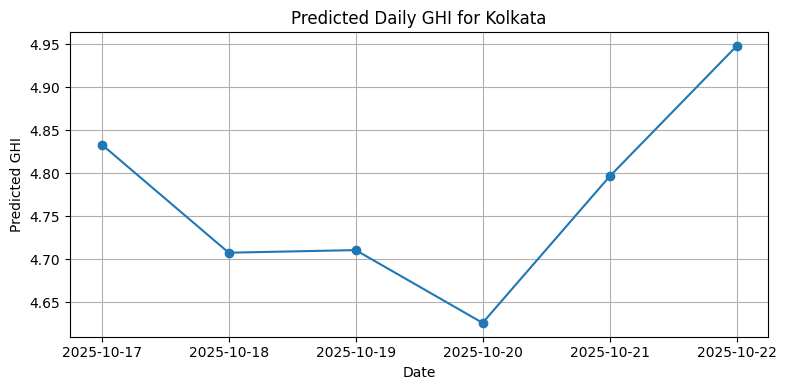

In [18]:
# --- Visualization ---
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(daily_df['date'], daily_df['Predicted_GHI'], marker='o')
plt.title(f"Predicted Daily GHI for {city}")
plt.xlabel("Date")
plt.ylabel("Predicted GHI")
plt.grid(True)
plt.tight_layout()
plt.show()